# DACON Collision detection using vibration data

In [1]:
import gc
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, GroupKFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor

import lightgbm  as lgb
from lightgbm import LGBMRegressor

# import xgboost  as xgb
# from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
import tensorflow_addons as tfa


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [16]:
# Read csv files

COLAB = True

if COLAB: path = '/content/drive/My Drive/ML Projects/DACON/Colision/data/'
else: path = '/ML Projects/DACON/data/'

def read_data(path=path):
    train_df = pd.read_csv(path+'train_features.csv',)     
    train_target = pd.read_csv(path+'train_target.csv', )  
    test_df = pd.read_csv(path+'test_features.csv', )                
    subm = pd.read_csv(path+"sample_submission.csv")
    print('Shape of train:', train_df.shape)
    print('Shape of solution:', test_df.shape)
    print('Shape of submision:', subm.shape)
    return train_df, train_target, test_df, subm

# Helpers

In [3]:
from tensorflow.keras.callbacks import Callback

class LRFinder(Callback):
    
    '''
    A simple callback for finding the optimal learning rate range for your model + dataset. 
    
    # Usage
        ```python
            lr_finder = LRFinder(min_lr=1e-5, 
                                 max_lr=1e-2, 
                                 steps_per_epoch=np.ceil(epoch_size/batch_size), 
                                 epochs=3)
            model.fit(X_train, Y_train, callbacks=[lr_finder])
            
            lr_finder.plot_loss()
        ```
    
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient. 
        
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: https://arxiv.org/abs/1506.01186
    '''
    
    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
 
    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        plt.show()
        
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.show()

In [4]:
from tensorflow.keras.callbacks import Callback

class WarmUpCosineDecayScheduler(Callback):
    """
        Cosine decay with warmup learning rate scheduler
    """
    def __init__(self,
                 learning_rate_base,
                 global_step_init=0,
                 warmup_learning_rate=0.0,
                 warmup_epoch=0,
                 hold_base_rate_steps=0,
                 learning_rate_final=None,
                 stop_epoch=None,
                 verbose=0):
        """Constructor for cosine decay with warmup learning rate scheduler.
        Arguments:
            learning_rate_base {float} -- base learning rate.
            total_steps {int} -- total number of training steps.
        Keyword Arguments:
            global_step_init {int} -- initial global step, e.g. from previous checkpoint.
            warmup_learning_rate {float} -- initial learning rate for warm up. (default: {0.0})
            warmup_steps {int} -- number of warmup steps. (default: {0})
            hold_base_rate_steps {int} -- Optional number of steps to hold base learning rate
                                        before decaying. (default: {0})
            verbose {int} -- 0: quiet, 1: update messages. (default: {0})
        """

        super(WarmUpCosineDecayScheduler, self).__init__()
        self.learning_rate_base = learning_rate_base
        self.global_step = global_step_init
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_epoch = warmup_epoch
        self.hold_base_rate_steps = hold_base_rate_steps
        self.learning_rates = []
        self.verbose = verbose
        self.stop_epoch = stop_epoch
        self.learning_rate_final = learning_rate_final
        self.epoch = 0

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch

    def on_batch_end(self, batch, logs=None):
        self.global_step = self.global_step + 1
        lr = K.get_value(self.model.optimizer.lr)
        self.learning_rates.append(lr)

    def on_batch_begin(self, batch, logs=None):
        total_steps = int(
            self.params['epochs'] * self.params['samples'] / self.params['batch_size'])
        warmup_steps = int(
            self.warmup_epoch * self.params['samples']  / self.params['batch_size'])
        lr = self.cosine_decay_with_warmup(
            global_step=self.global_step,
            learning_rate_base=self.learning_rate_base,
            total_steps=total_steps,
            warmup_learning_rate=self.warmup_learning_rate,
            warmup_steps=warmup_steps,
            hold_base_rate_steps=self.hold_base_rate_steps)
        if self.stop_epoch is not None and self.stop_epoch > 0 and self.epoch >= self.stop_epoch:
            if self.learning_rate_final is not None:
                K.set_value(self.model.optimizer.lr, self.learning_rate_final)
            else:
                self.learning_rate_final = lr
                K.set_value(self.model.optimizer.lr, self.learning_rate_final)
        else:
            K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nBatch %05d: setting learning '
                  'rate to %s.' % (self.global_step + 1, lr))

    def cosine_decay_with_warmup(self, global_step,
                                 learning_rate_base,
                                 total_steps,
                                 warmup_learning_rate=0.0,
                                 warmup_steps=0,
                                 hold_base_rate_steps=0):
        """Cosine decay schedule with warm up period.
        Cosine annealing learning rate as described in
            Loshchilov and Hutter, SGDR: Stochastic Gradient Descent with Warm Restarts.
            ICLR 2017. https://arxiv.org/abs/1608.03983
        In this schedule, the learning rate grows linearly from warmup_learning_rate
        to learning_rate_base for warmup_steps, then transitions to a cosine decay
        schedule.
        Arguments:
            global_step {int} -- global step.
            learning_rate_base {float} -- base learning rate.
            total_steps {int} -- total number of training steps.
        Keyword Arguments:
            warmup_learning_rate {float} -- initial learning rate for warm up. (default: {0.0})
            warmup_steps {int} -- number of warmup steps. (default: {0})
            hold_base_rate_steps {int} -- Optional number of steps to hold base learning rate
                                        before decaying. (default: {0})
        Returns:
            a float representing learning rate.
        Raises:
            ValueError: if warmup_learning_rate is larger than learning_rate_base,
            or if warmup_steps is larger than total_steps.
        """
        if total_steps < warmup_steps:
            raise ValueError('total_steps must be larger or equal to '
                             'warmup_steps.')
        learning_rate = 0.5 * learning_rate_base * (
            1 + np.cos(
                np.pi * (global_step - warmup_steps - hold_base_rate_steps) /
                float(total_steps - warmup_steps - hold_base_rate_steps)
                )
            )
        if hold_base_rate_steps > 0:
            learning_rate = np.where(global_step > warmup_steps + hold_base_rate_steps,
                                     learning_rate, learning_rate_base)
        if warmup_steps > 0:
            if learning_rate_base < warmup_learning_rate:
                raise ValueError('learning_rate_base must be larger or equal to '
                                 'warmup_learning_rate.')
            slope = (learning_rate_base - warmup_learning_rate) / warmup_steps
            warmup_rate = slope * global_step + warmup_learning_rate
            learning_rate = np.where(global_step < warmup_steps, warmup_rate,
                                     learning_rate)
        return np.where(global_step > total_steps, 0.0, learning_rate)

In [5]:
from tensorflow.keras.callbacks import Callback

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [6]:
def step_decay_schedule(initial_lr=1e-5, decay_factor=0.75, step_size=10):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    return tf.keras.callbacks.LearningRateScheduler(schedule, verbose=1)

In [11]:
class Mish(tf.keras.layers.Layer):

    def __init__(self, **kwargs):
        super(Mish, self).__init__(**kwargs)
        self.supports_masking = True

    def call(self, inputs):
        return inputs * K.tanh(K.softplus(inputs))

    def get_config(self):
        base_config = super(Mish, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape
def mish(x):
	return tf.keras.layers.Lambda(lambda x: x*K.tanh(K.softplus(x)))(x)
 
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import Activation
get_custom_objects().update({'mish': Activation(mish)})

In [33]:
def r2_keras(y_true, y_pred):
    K = tf.keras.backend
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [7]:
def kaeri_metric(y_true,  y_pred):

    '''
        y_true: dataframe with true values ​​of X,Y,M,V
        y_pred: dataframe with pred values ​​of X,Y,M,V

        return: KAERI metric
    '''
    
    _t1, _p1 = np.array(y_true)[:,:2], np.array(y_pred)[:,:2]
    E1 = np.mean(np.sum(np.square(_t1-_p1), axis=1) / 2e+04)
      
    _t2, _p2 = np.array(y_true)[:,2:], np.array(y_pred)[:,2:]
    E2 = np.mean(np.sum(np.square((_t2-_p2) / (_t2 + 1e-06)), axis=1))

    return 0.5*E1 + 0.5*E2
    # return  0.5*E1(y_true, y_pred ) + 0.5*E2( y_true, y_pred )


In [ ]:
from tensorflow.keras import backend as K

def kaeri_keras(y_true, y_pred):

    '''
    y_true: dataframe with true values ​​of X,Y,M,V
    y_pred: dataframe with pred values ​​of X,Y,M,V

    return: KAERI metric
    '''
    # K = tf.keras.backend

    # _t1, _ = tf.split(y_true, 2, 1)
    # _p1, _ = tf.split(y_pred, 2, 1)
    # _, _t2 = tf.split(y_true, 2, 1)
    # _, _p2 = tf.split(y_pred, 2, 1)
    _t1, _p1 = np.array(y_true)[:,:2], np.array(y_pred)[:,:2]
    _t2, _p2 = np.array(y_true)[:,2:], np.array(y_pred)[:,2:]
    E1 = K.mean(K.sum(K.square(_t1 - _p1), axis=1)/2e+04)
    E2 = K.mean(K.sum(K.square((_t2 - _p2) / (_t2 + 1e-06)), axis=1))

    return  0.5*E1 + 0.5*E2



In [8]:
def calc_ewm(s, windows=[10, 50]):
    '''
    Calculates exponential weighted functions
    '''
    ewm = pd.DataFrame()
    for w in windows:
        ewm['ewm_mean_' + str(w)] = s.ewm(span=w, min_periods=1).mean()
        ewm['ewm_std_' + str(w)] = s.ewm(span=w, min_periods=1).std()
    # add zeros when na values (std)
    ewm = ewm.fillna(value=0)       
    return ewm


def preprocess_data(df, cols=["S1","S2",'S3','S4']):

    sensor_cols = cols # ['S1','S2','S3','S4']

    df2 = pd.DataFrame(index=df.groupby(['id'])['id'].apply(pd.Series).unique())

    df2['Time'] = df['Time']

    for col in sensor_cols:
        df2[col+'_mean'] = df.groupby(['id'])[col].apply(lambda x: np.mean(x))
        df2[col+'_max'] = df.groupby(['id'])[col].apply(lambda x: np.max(x))
        df2[col+'_min'] = df.groupby(['id'])[col].apply(lambda x: np.min(x))
        df2[col+'_std'] = df.groupby(['id'])[col].apply(lambda x: np.std(x))
        df2[col+'_median'] = df.groupby(['id'])[col].apply(lambda x: np.median(x))

        df2[col+'_p10'] = df.groupby(['id'])[col].apply(lambda x: np.percentile(x, 10))
        df2[col+'_p25'] = df.groupby(['id'])[col].apply(lambda x: np.percentile(x, 25))
        df2[col+'_p75'] = df.groupby(['id'])[col].apply(lambda x: np.percentile(x, 75))
        df2[col+'_p90'] = df.groupby(['id'])[col].apply(lambda x: np.percentile(x, 90))
        df2[col+'_skew'] = df.groupby(['id'])[col].apply(lambda x: pd.Series(x).skew())
        # df2[col+'_kurtosis'] = df.groupby([col])[col].apply(lambda x: pd.Series(x).kurtosis())


        min_max = (df2[col+'_mean'] - df2[col+'_min']) / (df2[col+'_max'] - df2[col+'_min'])
        df2[col+'_norm'] = min_max * (np.floor(df2[col+'_max']) - np.ceil(df2[col+'_min']))
        df2[col+'_mean_abs_chg'] = df.groupby(['id'])[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        df2[col+'_abs_max'] = df.groupby(['id'])[col].apply(lambda x: np.max(np.abs(x)))
        df2[col+'_abs_min'] = df.groupby(['id'])[col].apply(lambda x: np.min(np.abs(x)))
        df2[col+'_range'] = df2[col+'_max'] - df2[col+'_min']
        df2[col+'_maxtomin'] = df2[col+'_max'] / df2[col+'_min']
        df2[col+'_abs_avg'] = (df2[col+'_abs_min'] + df2[col+'_abs_max']) / 2

        # ewm = calc_ewm(df[col])
        # ewm.columns = [col+'_'+n for n in ewm.columns]
        # df2 = pd.concat([df2, ewm], axis=1)

    return df2

In [13]:
def seed_everything(seed):
    
    # rn.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)



In [10]:
def batching(df : pd.DataFrame,
             batch_size : int) -> pd.DataFrame :
    
    df['group'] = df.groupby(df.index//batch_size, sort=False)['signal'].agg(['ngroup']).values
    df['group'] = df['group'].astype(np.uint16)
        
    return df



def lag_with_pct_change(df : pd.DataFrame,
                        shift_sizes,    # : Optional[List]=[1, 2],
                        add_pct_change,  #: Optional[bool]=False,
                        add_pct_change_lag, # : Optional[bool]=False) -> pd.DataFrame: 
):
    
    for shift_size in shift_sizes:    
        df['signal_shift_pos_'+str(shift_size)] = df.groupby('group')['signal'].shift(shift_size).fillna(0)
        df['signal_shift_neg_'+str(shift_size)] = df.groupby('group')['signal'].shift(-1*shift_size).fillna(0)

    if add_pct_change:
        df['pct_change'] = df['signal'].pct_change()
        if add_pct_change_lag:
            for shift_size in shift_sizes:    
                df['pct_change_shift_pos_'+str(shift_size)] = df.groupby('group')['pct_change'].shift(shift_size).fillna(0)
                df['pct_change_shift_neg_'+str(shift_size)] = df.groupby('group')['pct_change'].shift(-1*shift_size).fillna(0)
    return df



def run_feat_enginnering(df : pd.DataFrame,
                         create_all_data_feats : bool,
                         batch_size : int) -> pd.DataFrame:
    
    df = batching(df, batch_size=batch_size)
    if create_all_data_feats:
        df = lag_with_pct_change(df, [1, 2, 3],  add_pct_change=False, add_pct_change_lag=False)
    df['signal_2'] = df['signal'] ** 2
    return df

# Load data

In [17]:
SEED = 26
seed_everything(SEED)

train_df, targets, test_df, subm = read_data()

Shape of train: (1050000, 6)
Shape of solution: (262500, 6)
Shape of submision: (700, 5)


In [69]:
# train_df.info()
print(train_df.head())
print(test_df.head())
print(subm.head())

   id      Time   S1   S2   S3   S4
0   0  0.000000  0.0  0.0  0.0  0.0
1   0  0.000004  0.0  0.0  0.0  0.0
2   0  0.000008  0.0  0.0  0.0  0.0
3   0  0.000012  0.0  0.0  0.0  0.0
4   0  0.000016  0.0  0.0  0.0  0.0
     id      Time   S1   S2   S3   S4
0  2800  0.000000  0.0  0.0  0.0  0.0
1  2800  0.000004  0.0  0.0  0.0  0.0
2  2800  0.000008  0.0  0.0  0.0  0.0
3  2800  0.000012  0.0  0.0  0.0  0.0
4  2800  0.000016  0.0  0.0  0.0  0.0
     id           X           Y           M         V
0  2800 -251.151642  -33.210499  115.361504  0.415139
1  2801  306.643158 -297.179871   95.554611  0.416388
2  2802 -227.187210  130.209641   28.086653  0.354145
3  2803  155.305527  275.610199   26.912380  0.370306
4  2804 -155.184830  179.915222  135.617783  0.422606


In [ ]:
# train_df2 = preprocess_data(train_df, cols=['S1','S2','S3','S4'])
# test_df2 = preprocess_data(test_df, cols=['S1','S2','S3','S4'])

In [19]:
train_df.isnull().sum().sum(), test_df.isnull().sum().sum()

(0, 0)

In [ ]:
# print(test_df.head())
# test_df.shape

# EDA

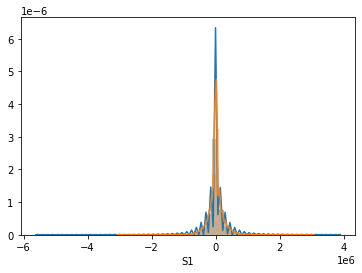

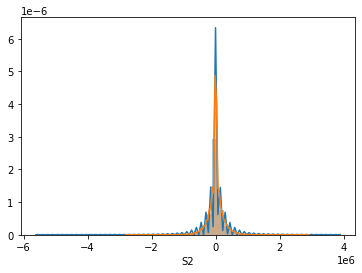

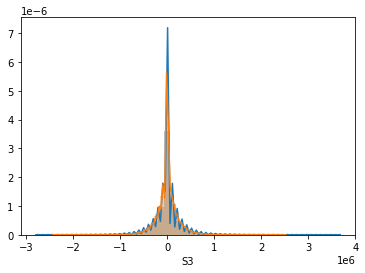

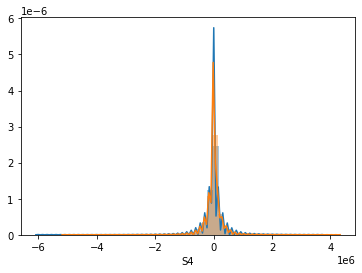

In [ ]:
# Inputs 
plt.figure()
sns.distplot(train_df.S1, label='train') 
sns.distplot(test_df.S1, label='test')

plt.figure()
sns.distplot(train_df.S2, label='train')
sns.distplot(test_df.S2, label='test')

plt.figure()
sns.distplot(train_df.S3, label='train') 
sns.distplot(test_df.S3, label='test')

plt.figure()
sns.distplot(train_df.S4, label='train') 
sns.distplot(test_df.S4, label='test')

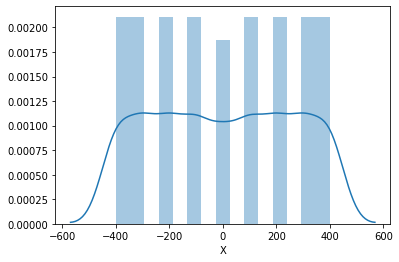

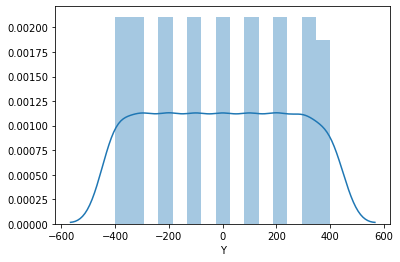

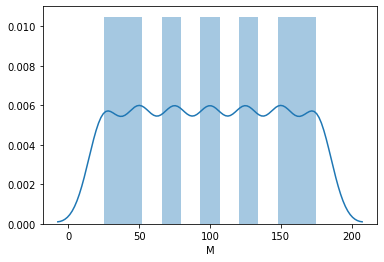

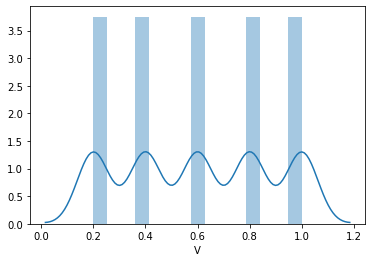

In [ ]:
# Targets
plt.figure()
sns.distplot(targets.X, label='train X') 
 
plt.figure()
sns.distplot(targets.Y, label='train Y') 

plt.figure()
sns.distplot(targets.M, label='train M') 

plt.figure()
sns.distplot(targets.V, label='train V') 

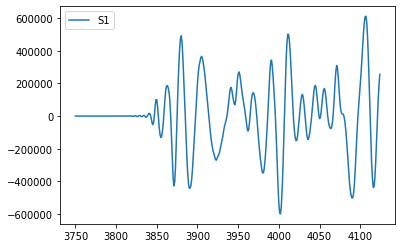

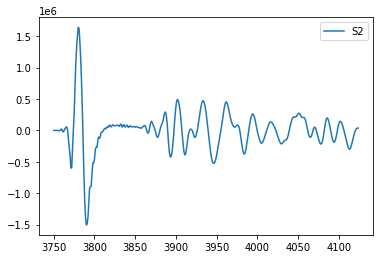

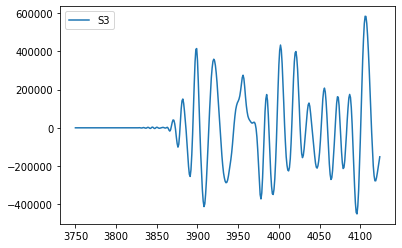

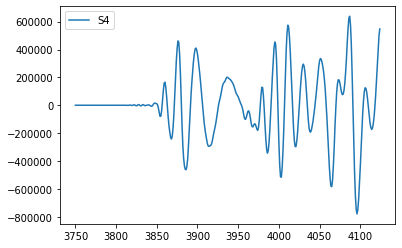

In [ ]:
idx = 10

train_df[train_df.id==idx][['S1']].plot()
train_df[train_df.id==idx][['S2']].plot()
train_df[train_df.id==idx][['S3']].plot()
train_df[train_df.id==idx][['S4']].plot()
# plt.plot(train_df[train_df.id==idx]['Time'], train_df[train_df.id==idx]['S1'])

In [ ]:
sig = train_df[train_df.id==idx][['S1']]

In [ ]:
sig[sig==0]

,S1
3750,0.0
3751,0.0
3752,0.0
3753,0.0
3754,0.0
...,...
4120,NaN
4121,NaN
4122,NaN
4123,NaN


In [ ]:
# # Source cols
# fig, ax = plt.subplots(nrows=7, ncols=5, sharex=True, figsize=(14, 14))
# fig.subplots_adjust(hspace=0.4)
# fig.suptitle('Distributions of src Features')
# for axis, feature, name in zip(ax.flatten(), train_df[cols_src], train_df[cols_src].columns):
#     sns.distplot(train_df[feature], ax=axis, bins=30)    
#     axis.set(title=name.upper(), xlabel='nm')


# fig, ax = plt.subplots(nrows=7, ncols=5, sharex=True, figsize=(14, 14))
# fig.subplots_adjust(hspace=0.4)
# fig.suptitle('Boxplots of src Features')
# for axis, feat, name in zip(ax.flatten(), train_df[cols_src], train_df[cols_src].columns):
#     sns.boxplot(train_df[feat], ax=axis)   
#     axis.set(title=name.upper(), xlabel='nm')

In [ ]:
# fig, ax = plt.subplots(nrows=7, ncols=5, sharex=True, figsize=(14, 14))
# fig.subplots_adjust(hspace=0.4)
# fig.suptitle('Boxplots of Features')

# for axis, feat, name in zip(ax.flatten(), train_df[cols_src], train_df[cols_src].columns):
#     sns.boxplot(train_df[feat], ax=axis)    
#     axis.set(title=name.upper(), xlabel='nm')

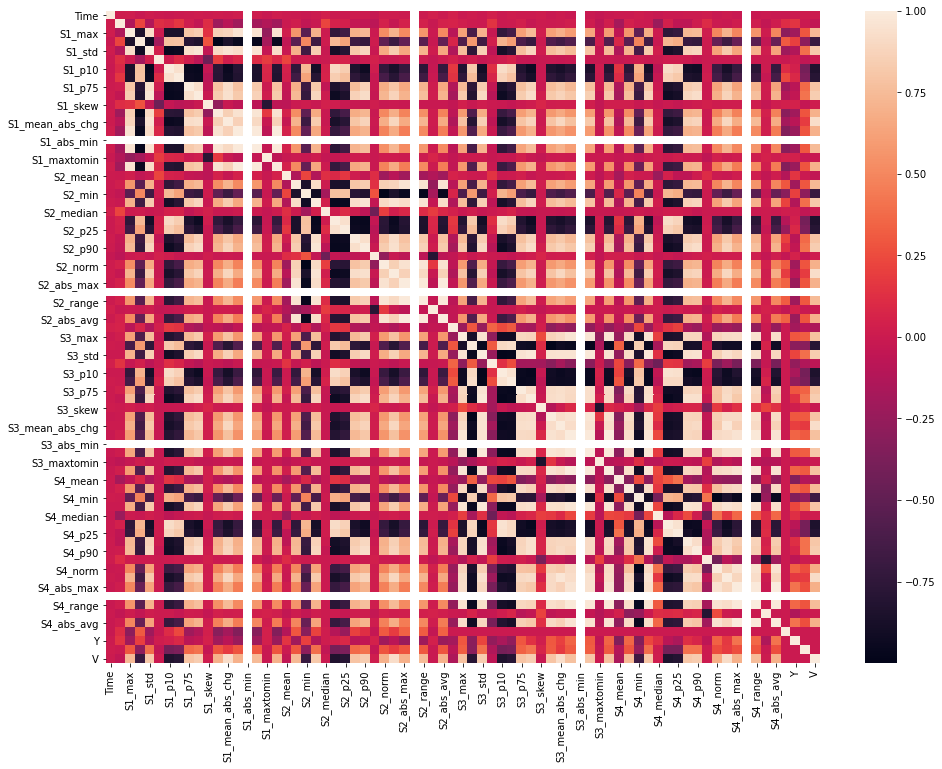

In [ ]:
plt.figure(figsize=(16,12))
sns.heatmap(pd.concat([train_df2[cols], targets.drop(['id'], axis=1)], axis=1).corr())

In [ ]:
# drop_cols = ['S1_kurtosis', 'S2_kurtosis', 'S3_kurtosis', 'S4_kurtosis']+['Time']

# cols =[col for col in  train_df2.columns if col not in drop_cols ]

target_cols = [col for col in targets.columns if col not in ['id'] ]

# len(cols), len(target_cols)

In [20]:
# cols
targets

,id,X,Y,M,V
0,0,0.0,-400.0,50.0,0.4
1,1,400.0,0.0,100.0,1.0
2,2,-300.0,-200.0,25.0,0.4
3,3,200.0,-100.0,150.0,0.4
4,4,-300.0,-100.0,150.0,0.4
...,...,...,...,...,...
2795,2795,200.0,200.0,50.0,1.0
2796,2796,-400.0,-400.0,150.0,0.2
2797,2797,-100.0,0.0,50.0,0.2
2798,2798,100.0,100.0,125.0,0.6


# CNN

In [86]:
# del model0, model1, model2, hist0, hist0_df, hist1, hist1_df, hist2, hist2_df
# gc.collect()

29352

In [87]:
SCALE = False   # True

if SCALE:     
    sc_inp = StandardScaler()
    X = sc_inp.fit_transform(train_df.iloc[:, 1:].values)
    X_test = sc_inp.transform(test_df.iloc[:, 1:].values)
else: 
    X = train_df.iloc[:, 1:].values
    X_test = test_df.iloc[:, 1:].values

# reshape arrays
X = X.reshape(2800, 375, 5, 1)
X_test = X_test.reshape(700, 375, 5, 1)
y = targets[['X', 'Y', 'M', 'V']]

X.shape, y.shape, X_test.shape

((2800, 375, 5, 1), (2800, 4), (700, 375, 5, 1))

In [88]:
weight1 = np.array([1,1,0,0])
weight2 = np.array([0,0,1,1])

def my_loss(y_true, y_pred):
    divResult = Lambda(lambda x: x[0]/x[1])([(y_pred-y_true),(y_true+0.000001)])
    return K.mean(K.square(divResult))


def my_loss_E1(y_true, y_pred):
    return K.mean(K.square(y_true-y_pred)*weight1)/2e+04

def my_loss_E2(y_true, y_pred):
    divResult = Lambda(lambda x: x[0]/x[1])([(y_pred-y_true),(y_true+0.000001)])
    return K.mean(K.square(divResult)*weight2)

In [ ]:
# x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=SEED)
# x_train.shape, x_valid.shape

In [89]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
import tensorflow.keras.backend as K


def build_cnn_model():

    activ = 'elu'        # 'relu'
    padding = 'valid'    # 'same'
    nf = 16
    fs = (5,1)    # (3,1)

    inp = Input(shape=X.shape[1:])

    # layer-1
    x = Conv2D(nf, fs, padding=padding, activation=activ)(inp)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 1))(x)
    
    # layer-2
    x =Conv2D(nf*2, fs, padding=padding, activation=activ)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 1))(x)

    # layer-3
    x = Conv2D(nf*4, fs, padding=padding, activation=activ)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 1))(x)

    # layer-4
    x = Conv2D(nf*8, fs, padding=padding, activation=activ)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 1))(x)

    # layer-5
    x = Conv2D(nf*16, fs, padding=padding, activation=activ)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 1))(x)

    # layer-6
    x = Conv2D(nf*32, fs, padding=padding, activation=activ)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 1))(x)

    # FC
    x = Flatten()(x)
    x = Dense(128, kernel_initializer='uniform', activation=activ)(x)
    # x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(64, kernel_initializer='uniform', activation=activ)(x)
    # x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(16, kernel_initializer='uniform', activation=activ)(x)
    # x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    out = Dense(4, kernel_initializer='uniform', activation='linear')(x)

    model = tf.keras.models.Model(inputs=[inp], outputs=[out])

    return model


def WaveNetResidualConv2D(num_filters, kernel_size, stacked_layer):

    def build_residual_block(l_input):
        resid_input = l_input
        for dilation_rate in [2**i for i in range(stacked_layer)]:
            l_sigmoid_conv1d = Conv1D(num_filters, kernel_size, dilation_rate=dilation_rate, padding='same', activation='sigmoid')(l_input)
            l_tanh_conv1d = Conv1D(num_filters, kernel_size, dilation_rate=dilation_rate, padding='same', activation='mish')(l_input)
            l_input = Multiply()([l_sigmoid_conv1d, l_tanh_conv1d])
            l_input = Conv1D(num_filters, 1, padding='same')(l_input)
            resid_input = Add()([resid_input, l_input])
        return resid_input
    return build_residual_block

def build_wavenet():    # shape_
    num_filters_ = 16
    kernel_size_ = 3
    stacked_layers_ = [12, 8, 4, 1]
    l_input = Input(shape=X.shape[1:])
    x = Conv1D(num_filters_, 1, padding='same')(l_input)
    x = WaveNetResidualConv2D(num_filters_, kernel_size_, stacked_layers_[0])(x)
    x = Conv1D(num_filters_*2, 1, padding='same')(x)
    x = WaveNetResidualConv2D(num_filters_*2, kernel_size_, stacked_layers_[1])(x)
    x = Conv1D(num_filters_*4, 1, padding='same')(x)
    x = WaveNetResidualConv2D(num_filters_*4, kernel_size_, stacked_layers_[2])(x)
    x = Conv1D(num_filters_*8, 1, padding='same')(x)
    x = WaveNetResidualConv2D(num_filters_*8, kernel_size_, stacked_layers_[3])(x)

    # FC
    x = Flatten()(x)
    x = Dense(256, kernel_initializer='uniform', activation='elu')(x)
    # x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(128, kernel_initializer='uniform', activation='elu')(x)
    # x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(64, kernel_initializer='uniform', activation='elu')(x)
    # x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    l_output = Dense(4, activation='linear')(x)

    model = tf.keras.models.Model(inputs=[l_input], outputs=[l_output])
    # opt = tf.keras.optimizers.Adam(lr=LR)
    # opt = tfa.optimizers.SWA(opt)
    # model.compile(loss=losses.CategoricalCrossentropy(), optimizer=opt, metrics=['accuracy'])
    return model    


def build_wavenet2():
    
    def wave_block(x, filters, kernel_size, n):
        dilation_rates = [2**i for i in range(n)]
        x = Conv1D(filters=filters, kernel_size=1, padding='same')(x)
        res_x = x
        for dilation_rate in dilation_rates:
            tanh_out = Conv1D(filters=filters, kernel_size=kernel_size, padding='same', 
                              activation='tanh', dilation_rate=dilation_rate)(x)
            sigm_out = Conv1D(filters=filters, kernel_size=kernel_size, padding = 'same',
                              activation='sigmoid', dilation_rate=dilation_rate)(x)
            x = Multiply()([tanh_out, sigm_out])
            x = Conv1D(filters=filters, kernel_size=1, padding='same')(x)
            res_x = Add()([res_x, x])
        return res_x
    
    inp = Input(shape=X.shape[1:])
    x = wave_block(inp, 16, 3, 12)
    x = wave_block(x, 32, 3, 8)
    x = wave_block(x, 64, 3, 4)
    x = wave_block(x, 128, 3, 1)

    # FC
    x = Flatten()(x)
    x = Dense(256, kernel_initializer='uniform', activation='elu')(x)
    # x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(128, kernel_initializer='uniform', activation='elu')(x)
    # x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(64, kernel_initializer='uniform', activation='elu')(x)
    # x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    out = Dense(4, activation='linear', name='out')(x)
    
    model = models.Model(inputs = inp, outputs = out)
    return model    

In [25]:
build_cnn_model().summary()

# build_wavenet().summary()

# model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 375, 5, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 373, 5, 16)        64        
_________________________________________________________________
batch_normalization (BatchNo (None, 373, 5, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 186, 5, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 184, 5, 32)        1568      
_________________________________________________________________
batch_normalization_1 (Batch (None, 184, 5, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 92, 5, 32)         0     

### Model #0: Train for X,y

88/88 [==============================] - 2s 20ms/step - loss: 1.5592


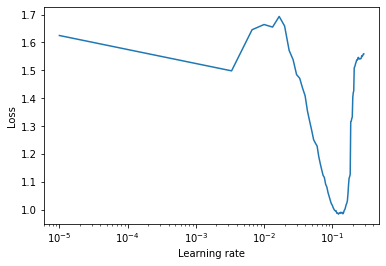

10711

In [31]:
train_target = 0

# compile model
BATCH_SIZE = 256
EPOCHS = 300
LR = 0.001

optimizer = tf.keras.optimizers.Adam()

global weight2
if train_target == 1: 
    # only for M
    weight2 = np.array([0,0,1,0])
else: 
    # only for V
    weight2 = np.array([0,0,0,1])
    
# if train_target==0:
model = build_cnn_model()
model.compile(loss=my_loss_E1, optimizer=optimizer)

# Find optimal LR 
lr_finder = LRFinder(min_lr=1e-5, max_lr=1e-1, steps_per_epoch=10, epochs=3)
model.fit(X, y, callbacks=[lr_finder])

plt.figure()
lr_finder.plot_loss()

# plt.figure()
# lr_finder.plot_lr()

del model 
gc.collect()

In [91]:
train_target = 0

LR = 0.01

model0 = build_cnn_model()
optimizer = tf.keras.optimizers.Adam()
optimizer = tfa.optimizers.SWA(optimizer)

global weight2
if train_target == 1: 
    # only for M
    weight2 = np.array([0,0,1,0])
else: 
    # only for V
    weight2 = np.array([0,0,0,1])
    
model0.compile(loss=my_loss_E1, optimizer=optimizer, metrics=[r2_keras])

# callbacks
MODEL_PATH = '/content/drive/My Drive/ML Projects/DACON/Colision/'
MODEL_NAME = 'CNN_model_3a.h5'      # _epoch{epoch:02d}_loss{val_loss:.2f}

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
mc = tf.keras.callbacks.ModelCheckpoint(MODEL_PATH+MODEL_NAME, monitor='val_loss', save_best_only=True, save_weights_only=False, verbose=1)

# select LR schedule Callback
# ---------------------------
# rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=10, verbose=1, factor=0.7)
# lr_schedule = step_decay_schedule(initial_lr=1e-2, decay_factor=0.5, step_size=5)
lr_cyclic = CyclicLR(base_lr=0.001, max_lr=0.006, step_size=25., mode='exp_range', gamma=0.99994)
# lr_cos = WarmUpCosineDecayScheduler()

callbacks=[es,  mc, lr_cyclic]             
# lr_cyclic, lr_cos, 


In [92]:
print('Train CNN model #3 for X,Y')   # kernel 5 + SWA
print()

hist0 = model0.fit(X, y,                   
                 validation_split=0.2,    
                 batch_size=BATCH_SIZE,
                 epochs=EPOCHS,
                 verbose=1,
                 shuffle=True,
                 callbacks=callbacks)

Train CNN model #3 for X,Y

Epoch 1/200
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
9/9 [==============================] - ETA: 0s - loss: 1.6620 - r2_keras: -0.0149
Epoch 00001: val_loss improved from inf to 1.64005, saving model to /content/drive/My Drive/ML Projects/DACON/Colision/CNN_model_3a.h5
9/9 [==============================] - 4s 402ms/step - loss: 1.6620 - r2_keras: -0.0149 - val_loss: 1.6401 - val_r2_keras: -0.0083
Epoch 2/200
9/9 [==============================] - ETA: 0s - loss: 1.4930 - r2_keras: 0.0826
Epoch 00002: val_loss improved from 1.64005 to 0.90145, saving model to /content/drive/My Drive/ML Projects/DACON/Colision/CNN_model_3a.h5
9/9 [==============================] - 1s 135ms/step - loss: 1.4930 - r2_keras: 0.0826 - val_loss: 0.9015 - val_r2_keras: 0.3942
Epoch 3/200
9/9 [==============================] - ETA: 0s - loss: 0.5099 - r2_keras: 0.5989
Epoch 00003: val_loss did not improve from 0.90145
9/9 [=====================

(0.0, 2.0)

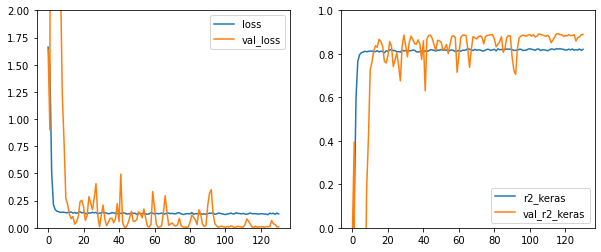

In [93]:
hist0_df =pd.DataFrame(hist0.history)

fig, ax = plt.subplots(1,2, figsize=(10, 4))
hist0_df[['loss', 'val_loss']].plot(ax=ax[0])
hist0_df[['r2_keras', 'val_r2_keras']].plot(ax=ax[1])
ax[1].set_ylim([0.0, 1.0])
ax[0].set_ylim([0.0, 2.0])
# hist0_df.columns.tolist()

In [94]:
hist0_df[['val_loss']].min(), np.argmin(hist0_df[['val_loss']])

(val_loss    0.001897
 dtype: float64, 105)

In [ ]:
# model0_cp = tf.keras.models.load_model(MODEL_PATH+'CNN_model_2a.h5')
# y_pred_valid = model0_cp.predict(x_valid)

CNN Model 2

Adam + cyclic lr exp(0.001-0.006)  val_loss = 0.002392

### Model #2: Train for M 

In [100]:
train_target = 1

# compile model
BATCH_SIZE = 256
EPOCHS = 200
LR = 0.001

model1 = build_cnn_model()
# model1 = build_wavenet()

optimizer = tf.keras.optimizers.Adam()
optimizer = tfa.optimizers.SWA(optimizer)

global weight2
if train_target == 1: 
    # only for M
    weight2 = np.array([0,0,1,0])
else: 
    # only for V
    weight2 = np.array([0,0,0,1])
    
model1.compile(loss=my_loss_E2, optimizer=optimizer)   # metrics=   [r2_keras]tf.keras.metrics.MAPE


# callbacks
MODEL_PATH = '/content/drive/My Drive/ML Projects/DACON/Colision/'
MODEL_NAME = 'CNN_model_3b.h5'      # _epoch{epoch:02d}_loss{val_loss:.2f}

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
mc = tf.keras.callbacks.ModelCheckpoint(MODEL_PATH+MODEL_NAME, monitor='val_loss', save_best_only=True, save_weights_only=False, verbose=1)

# select LR schedule Callback
# ---------------------------
# rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=10, verbose=1, factor=0.7)
# lr_schedule = step_decay_schedule(initial_lr=1e-2, decay_factor=0.5, step_size=5)
lr_cyclic = CyclicLR(base_lr=0.001, max_lr=0.006, step_size=25., mode='exp_range', gamma=0.99994)
# lr_cos = WarmUpCosineDecayScheduler()

callbacks=[es, mc, lr_cyclic]             
# , rlr, lr_cos, lr_cyclic


In [101]:
print('Train CNN Model #3 for M')
print()

hist1 = model1.fit(X, y,                
                 validation_split=0.2,     
                 batch_size=BATCH_SIZE,
                 epochs=EPOCHS,
                 verbose=1,
                 shuffle=True,
                 callbacks=callbacks)

Train CNN Model #3 for M

Epoch 1/200
9/9 [==============================] - ETA: 0s - loss: 0.2471 - mean_absolute_percentage_error: 4354997.5000
Epoch 00001: val_loss improved from inf to 0.24242, saving model to /content/drive/My Drive/ML Projects/DACON/Colision/CNN_model_3b.h5
9/9 [==============================] - 3s 320ms/step - loss: 0.2471 - mean_absolute_percentage_error: 4354997.5000 - val_loss: 0.2424 - val_mean_absolute_percentage_error: 7538326.5000
Epoch 2/200
9/9 [==============================] - ETA: 0s - loss: 0.1677 - mean_absolute_percentage_error: 91567928.0000
Epoch 00002: val_loss did not improve from 0.24242
9/9 [==============================] - 1s 98ms/step - loss: 0.1677 - mean_absolute_percentage_error: 91567928.0000 - val_loss: 0.6979 - val_mean_absolute_percentage_error: 660526912.0000
Epoch 3/200
9/9 [==============================] - ETA: 0s - loss: 0.0454 - mean_absolute_percentage_error: 351588864.0000
Epoch 00003: val_loss did not improve from 0.24242

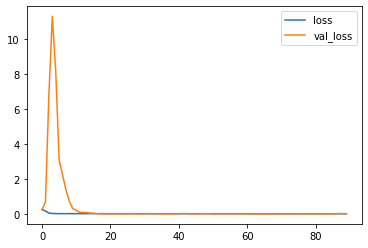

In [102]:
hist1_df =pd.DataFrame(hist1.history)
hist1_df[['loss', 'val_loss']].plot()

In [103]:
hist1_df[['val_loss']].min(), np.argmin(hist1_df[['val_loss']])

(val_loss    0.000503
 dtype: float64, 64)

CNN Model1-b rlr val_loss = 0.04020 

CNN Model2-b cyclic lr val_loss = 0.00045

In [ ]:
# model1_cp = tf.keras.models.load_model(MODEL_PATH+'CNN_model_2b.h5')

### Model #3: Train for V 

In [104]:
train_target = 2

# compile model
# BATCH_SIZE = 256
# EPOCHS = 200
# LR = 0.001

model2 = build_cnn_model()

optimizer = tf.keras.optimizers.Adam()
optimizer = tfa.optimizers.SWA(optimizer)

# global weight2
if train_target == 1: 
    # only for M
    weight2 = np.array([0,0,1,0])
else: 
    # only for V
    weight2 = np.array([0,0,0,1])
    

model2.compile(loss=my_loss_E2, optimizer=optimizer, )   # metrics=[r2_keras]


# callbacks
MODEL_PATH = '/content/drive/My Drive/ML Projects/DACON/Colision/'
MODEL_NAME = 'CNN_model_3c.h5'      # _epoch{epoch:02d}_loss{val_loss:.2f}

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
mc = tf.keras.callbacks.ModelCheckpoint(MODEL_PATH+MODEL_NAME, monitor='val_loss', save_best_only=True, save_weights_only=False, verbose=1)

# select LR schedule Callback
# rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=10, verbose=1, factor=0.7)
# lr_schedule = step_decay_schedule(initial_lr=1e-2, decay_factor=0.5, step_size=5)
lr_cyclic = CyclicLR(base_lr=0.001, max_lr=0.006, step_size=25., mode='exp_range', gamma=0.99994)
# lr_cos = WarmUpCosineDecayScheduler()

callbacks=[es, mc, lr_cyclic]             
# ,rlr , lr_cos, lr_cyclic

In [105]:
hist2 = model2.fit(X, y,               
                 validation_split=0.2,     
                 batch_size=BATCH_SIZE,
                 epochs=EPOCHS,
                 verbose=1,
                 shuffle=True,
                 callbacks=callbacks)

Epoch 1/200
9/9 [==============================] - ETA: 0s - loss: 0.0871
Epoch 00001: val_loss improved from inf to 3.46859, saving model to /content/drive/My Drive/ML Projects/DACON/Colision/CNN_model_3c.h5
9/9 [==============================] - 1s 154ms/step - loss: 0.0871 - val_loss: 3.4686
Epoch 2/200
9/9 [==============================] - ETA: 0s - loss: 0.0187
Epoch 00002: val_loss improved from 3.46859 to 0.97438, saving model to /content/drive/My Drive/ML Projects/DACON/Colision/CNN_model_3c.h5
9/9 [==============================] - 1s 127ms/step - loss: 0.0187 - val_loss: 0.9744
Epoch 3/200
9/9 [==============================] - ETA: 0s - loss: 0.0099
Epoch 00003: val_loss did not improve from 0.97438
9/9 [==============================] - 1s 97ms/step - loss: 0.0099 - val_loss: 4.2096
Epoch 4/200
9/9 [==============================] - ETA: 0s - loss: 0.0075
Epoch 00004: val_loss did not improve from 0.97438
9/9 [==============================] - 1s 97ms/step - loss: 0.0075 -

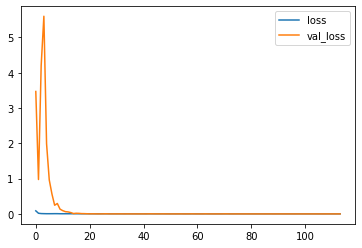

In [106]:
hist2_df =pd.DataFrame(hist2.history)
hist2_df[['loss', 'val_loss']].plot()

In [107]:
hist2_df[['val_loss']].min(), np.argmin(hist2_df[['val_loss']])

(val_loss    0.000033
 dtype: float64, 88)

# Predict Test set

In [108]:
model0_cp = tf.keras.models.load_model(MODEL_PATH+'CNN_model_3a.h5', custom_objects={'my_loss_E1': my_loss, 'r2_keras':r2_keras})
model1_cp = tf.keras.models.load_model(MODEL_PATH+'CNN_model_3b.h5', custom_objects={'my_loss_E2': my_loss})
model2_cp = tf.keras.models.load_model(MODEL_PATH+'CNN_model_3c.h5', custom_objects={'my_loss_E2': my_loss})

In [109]:
subm.head()

,id,X,Y,M,V
0,2800,-251.151642,-33.210499,115.361504,0.415139
1,2801,306.643158,-297.179871,95.554611,0.416388
2,2802,-227.187210,130.209641,28.086653,0.354145
3,2803,155.305527,275.610199,26.912380,0.370306
4,2804,-155.184830,179.915222,135.617783,0.422606


In [110]:
# Target 0
test_preds = model0_cp.predict(X_test)
subm.iloc[:,1] = test_preds[:,0]
subm.iloc[:,2] = test_preds[:,1]

# Target 1
test_preds = model1_cp.predict(X_test)
subm.iloc[:,3] = test_preds[:,2]

# Target 2
test_preds = model2_cp.predict(X_test)
subm.iloc[:,4] = test_preds[:,3]

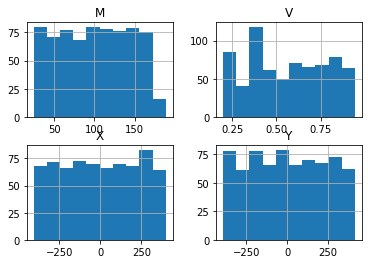

In [111]:
subm.iloc[:, 1:].hist();

# Submission

In [113]:
subm.to_csv('submission_cnn3.csv', index=False)

In [114]:
subm.head()

,id,X,Y,M,V
0,2800,-250.971191,-29.678473,109.553986,0.409991
1,2801,304.797089,-280.788208,89.494713,0.405074
2,2802,-245.229309,132.538406,32.327354,0.377066
3,2803,153.611145,261.543152,28.577295,0.385241
4,2804,-141.282501,185.007446,132.431122,0.408162


`LB = 0.01474`

- CNN Model1-a rlr 
- CNN Model1-b rlr  `val_loss=0.04020`
- CNN Model1-c rlr 


--------------------------------------------------
`LB = 0.01103`

- CNN Model2-a cyclic lr `val_loss=0.002392`
- CNN Model2-b cyclic lr `val_loss=0.00045`
- CNN Model2-c cyclic lr `val_loss=0.000064`

--------------------------------------------------

`LB = 0.00966`  Pos. 5

- CNN Model3-a cyclic+SWA+k5 `val_loss=0.0018968`
- CNN Model3-b cyclic+SWA+k5 `val_loss=0.0005028`
- CNN Model3-c cyclic+SWA+k5 `val_loss=3.3e-05`


In [124]:
# np.round(hist2_df['val_loss'].min(), 6)

# Inference schemes

In [ ]:
# model_cp = tf.keras.models.load_model(MODEL_PATH+MODEL_NAME)

# model_cp

In [ ]:
def kfold_inference_lgb(models):
    # for OUT in range(3):
    #     preds_ = []
    preds_out = []
    for model in models:
        if  preds_out == []:
            preds_out = model.predict(test,  num_iteration=model.best_iteration) / len(models)
        else:
            preds_out += model.predict(test, num_iteration=model.best_iteration) / len(models)
    return preds_out


def kfold_inference_hgb(models):
    preds_out = []
    for model in models:
        if  preds_out == []:
            preds_out = model.predict(test) / len(models)
        else:
            preds_out += model.predict(test) / len(models)
    return preds_out


def kfold_inference_cb(models):
    preds_all = np.zeros((len(test), 4))
    for OUT in range(3):
        preds_ = []
        for model in models[OUT]:
            if  preds_ == []:
                preds_ = model.predict(test) / len(models[OUT])
            else:
                preds_ += model.predict(test) / len(models[OUT])
        
        preds_all[:, OUT] = preds_

    return preds_all

In [ ]:
# # Inference LGBM

# test_preds_lgb = np.zeros((len(test), 4))

# test_preds_lgb[:, 0] = kfold_inference_lgb(models_lgb_outs[0]) 
# test_preds_lgb[:, 1] = kfold_inference_lgb(models_lgb_outs[1])
# test_preds_lgb[:, 2] = kfold_inference_lgb(models_lgb_outs[2])
# test_preds_lgb[:, 3] = kfold_inference_lgb(models_lgb_outs[3])

# pd.DataFrame(test_preds_lgb).plot(kind='hist')

In [ ]:
# # KFold Inference HistGB

# test_preds_hgb = np.zeros((len(test), 4))

# test_preds_hgb[:, 0] = kfold_inference_hgb(models_hgb_outs[0])    
# test_preds_hgb[:, 1] = kfold_inference_hgb(models_hgb_outs[1])
# test_preds_hgb[:, 2] = kfold_inference_hgb(models_hgb_outs[2])
# test_preds_hgb[:, 3] = kfold_inference_hgb(models_hgb_outs[3])

# pd.DataFrame(test_preds_hgb).plot(kind='hist')

In [ ]:
# # Inference Catboost

# preds_cb = kfold_inference_cb(models_cb_outs)

In [ ]:
# fig, ax = plt.subplots(2, 2)
# ax = ax.flatten()
# sns.distplot(preds_out1, ax=ax[0]);
# # sns.distplot(test_preds_lgb[:,0], ax=ax[0]);
# # sns.distplot(preds_cb[:,0], ax=ax[0]);
# sns.distplot(preds_out2, ax=ax[1]);
# # sns.distplot(test_preds_lgb[:,1], ax=ax[1]);
# # sns.distplot(test_preds_hgb[:,2], ax=ax[2]);
# sns.distplot(preds_out3, ax=ax[2]);
# # sns.distplot(test_preds_hgb[:,3], ax=ax[3]);
# sns.distplot(preds_out4, ax=ax[3]);
# # plt.legend(['hgb', 'lgb'])

In [ ]:
# find optimal weights 
from tqdm import tqdm

def find_ensemble_weights(y_valid, pred1, pred2, plot=False):

    scores = []
    alphas = np.linspace(0,1,101)  # 101

    # loop for every alpha
    for alpha in tqdm(alphas):
        mae_ = mean_absolute_error(y_valid, alpha*pred1 + (1 - alpha)*pred2)
        scores.append(mae_)

    # convert to numpy array
    scores = np.array(scores)

    # get best_alpha
    best_alpha = alphas[np.argmin(scores)]

    print()
    print('best_mae=', scores.min())
    print('best_alpha weight=', best_alpha)

    if plot: 
        plt.plot(alphas, scores)
        plt.title('mae_score for ensemble')
        plt.xlabel('alpha')
        plt.ylabel('mae_score')

    return best_alpha


In [ ]:
# pred1 = []
# for model in models_hgb_1:
#     if pred1 == []:
#         pred1 = model.predict(x_valid) / len(models_hgb_1)
#     else: 
#         pred1 += model.predict(x_valid) / len(models_hgb_1)

# pred2 = []
# for model in models_cb_outs[0]:     # models_lgb_1
#     if pred2 == []:
#         pred2 = model.predict(x_valid) / len(models_lgb_1)
#     else:   
#         pred2 += model.predict(x_valid) / len(models_lgb_1)

In [ ]:
# # pred1.shape, pred2.shape

# alpha_out1 = find_ensemble_weights(y_valid.iloc[:, 0], pred1, pred2, plot=True)